## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = [32, 128]
MOMENTUM = 0.95

In [7]:
results = {}

for b_size in BATCH_SIZE:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=b_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    
    results[str(b_size)] = {'train_loss': train_loss,
                        'valid_loss': valid_loss,
                        'train_acc': train_acc,
                        'valid_acc': valid_acc}





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
______

50000/50000 [==============================] - 18s 369us/step - loss: 1.1732 - acc: 0.5884 - val_loss: 1.4471 - val_acc: 0.4924
Epoch 8/10
50000/50000 [==============================] - 18s 369us/step - loss: 1.1329 - acc: 0.6045 - val_loss: 1.4431 - val_acc: 0.4898
Epoch 9/10
50000/50000 [==============================] - 18s 370us/step - loss: 1.0900 - acc: 0.6193 - val_loss: 1.4675 - val_acc: 0.4875
Epoch 10/10
50000/50000 [==============================] - 18s 368us/step - loss: 1.0493 - acc: 0.6312 - val_loss: 1.4432 - val_acc: 0.5064


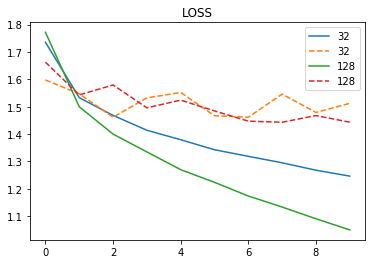

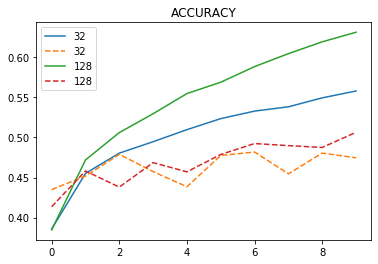

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_loss'])), results[n]['train_loss'], '-', label=n)
    plt.plot(range(len(results[n]['valid_loss'])), results[n]['valid_loss'], '--', label=n)
    plt.legend()
    plt.title('LOSS')
plt.show()

for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_acc'])), results[n]['train_acc'], '-', label=n)
    plt.plot(range(len(results[n]['valid_acc'])), results[n]['valid_acc'], '--', label=n)
    plt.legend()
    plt.title('ACCURACY')
plt.show()

In [9]:
def build_mlp_before_activ(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1))(input_layer)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [10]:
results = {}

for b_size in BATCH_SIZE:
    model = build_mlp_before_activ(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=b_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    
    results[str(b_size)] = {'train_loss': train_loss,
                        'valid_loss': valid_loss,
                        'train_acc': train_acc,
                        'valid_acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total para

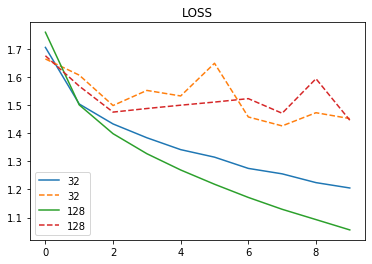

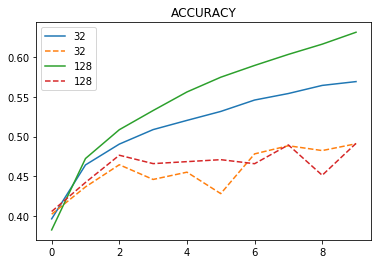

In [11]:
for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_loss'])), results[n]['train_loss'], '-', label=n)
    plt.plot(range(len(results[n]['valid_loss'])), results[n]['valid_loss'], '--', label=n)
    plt.legend()
    plt.title('LOSS')
plt.show()

for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_acc'])), results[n]['train_acc'], '-', label=n)
    plt.plot(range(len(results[n]['valid_acc'])), results[n]['valid_acc'], '--', label=n)
    plt.legend()
    plt.title('ACCURACY')
plt.show()

In [12]:
def build_mlp_after_inputlayer(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1))(x)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer'+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [13]:
results = {}

for b_size in BATCH_SIZE:
    model = build_mlp_after_inputlayer(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=b_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    
    results[str(b_size)] = {'train_loss': train_loss,
                        'valid_loss': valid_loss,
                        'train_acc': train_acc,
                        'valid_acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________

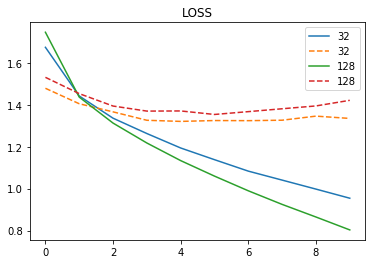

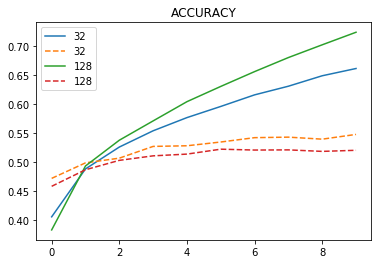

In [14]:
for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_loss'])), results[n]['train_loss'], '-', label=n)
    plt.plot(range(len(results[n]['valid_loss'])), results[n]['valid_loss'], '--', label=n)
    plt.legend()
    plt.title('LOSS')
plt.show()

for i,n in enumerate(results.keys()):
    plt.plot(range(len(results[n]['train_acc'])), results[n]['train_acc'], '-', label=n)
    plt.plot(range(len(results[n]['valid_acc'])), results[n]['valid_acc'], '--', label=n)
    plt.legend()
    plt.title('ACCURACY')
plt.show()